In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
from matplotlib.patches import Ellipse
from matplotlib import gridspec
import scienceplots
import warnings
import h5py

import ppxf.ppxf_util as util

from astropy.utils.exceptions import AstropyWarning
import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting,polynomial
import astropy.modeling as modeling
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

import sep
from photutils.aperture import EllipticalAperture, SkyEllipticalAperture
from photutils.psf import PSFPhotometry,FittableImageModel,IterativePSFPhotometry
from photutils.detection import DAOStarFinder

import os, sys, glob, pdb
os.environ["SPS_HOME"]="/disk/bifrost/yuanze/software/fsps"

from importlib import reload
from reproject import reproject_interp
from regions import Regions
import linetools

import fsps
import sedpy
import prospect
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log, chi_spec, chi_phot
from prospect.fitting import fit_model,lnprobfn

import emcee
import dynesty

In [3]:
KBSSpath="/disk/bifrost/yuanze/KBSS"
multiAGNpath="/disk/bifrost/yuanze/multiAGN"
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")

obj=1
sourcename="UGC2369_{}".format(obj)
field="UGC2369"


sentry = stab[stab["Field"]==field]

ra = np.mean(sentry["RA"].value)
dec = np.mean(sentry["Dec"].value)
sc=SkyCoord(ra=ra,dec=dec,unit="deg")

z=sentry["z_sys"][obj-1]

In [4]:
from prospect.models.sedmodel import SpecModel
from prospect.models.templates import TemplateLibrary,adjust_continuity_agebins
from prospect.models import priors
reload(prospect.models.templates)
def build_obs(snr=10, ldist=10.0, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for UGC 2369
    
    :param snr:
        The S/N assumed to the photometry
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    #galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
    #sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    filternames = spitzer
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    #M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86, 
    #                 -14.94, -14.09, -13.62, -13.23, -12.78])
    #dm = 25 + 5.0 * np.log10(ldist)
    #mags = M_AB + dm
    #1 maggie is the flux density in Janskys divided by 3631
    obs["maggies"] = None#10**(-0.4*mags)

    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = None#(1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we mask the spitzer bands.
    obs["phot_mask"] = None#np.array(['spitzer' in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = None#np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    specinstru="MUSE"#,"OSIRIS"]
    
    datapath=os.path.join(multiAGNpath,field)
    path_out = os.path.join(datapath, '{}_1D'.format(specinstru))
    
    data = np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_obj{}.txt".format(specinstru,obj)))
    lam = data[:,0]  # OBS wavelength [A]
    flux = data[:,1]*1e-20  # OBS flux [erg/s/cm^2/A]
    err = data[:,2]*1e-20  # 1 sigma error
    
    specmaggies = 3.33564095e4*flux*lam**2 / 3631
    specunc = 3.33564095e4*err*lam**2 / 3631
    
    obs["wavelength"] = lam
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = specmaggies
    # (spectral uncertainties are given here)
    obs['unc'] = specunc
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    #mask0 = util.determine_mask(np.log(lam), [lam[0],lam[-1]], z, width=1000)
    zf=1+z
    mask = (specmaggies>0.001*np.median(specmaggies)) &((lam<5400)| (lam>6120)) &((lam<6500*zf)| (lam>6765*zf))
    
    obs['mask'] = mask

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None,
                add_duste=False,add_neb=False, add_dispersion=False,**extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    
    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    #model_params = TemplateLibrary["parametric_sfh"]
    # Use the non-parametric SFH with continuity prior
    model_params = TemplateLibrary["continuity_sfh"]
    adjust_continuity_agebins(model_params,nbins=8)
    #model_params.update(TemplateLibrary["burst_sfh"])
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = z
    model_params["dust2"]["init"] = 1.0
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.5, maxi=2.0)
    model_params["dust_type"]["init"] = 2
    model_params["imf_type"]["init"] = 0
    model_params["logzsol"]["init"] = -0.5
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-2, maxi=0.0)
    model_params["logmass"]["prior"] = priors.TopHat(mini=8, maxi=11)
    
    #model_params["tage"]["init"] = 13.7
    '''
    model_params["tburst"]["init"] = 0.5 #burst time 
    model_params["fburst"]["init"] = 0.2
    model_params["mass"]["init"] = 1e10

    model_params["tage"]["isfree"] = False # fix the total age to 13.6 Gyr
    model_params["fage_burst"]["isfree"] = True
    #model_params["tburst"]["isfree"] = False
    model_params["fburst"]["isfree"] = True
    '''
    # These are starburst galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward

    #model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    #model_params["mass"]["prior"] = priors.LogUniform(mini=1e8, maxi=1e11)
    #model_params["fburst"]["prior"] = priors.TopHat(mini=0.0, maxi=0.5)
    #model_params["tburst"]["prior"] = priors.LogUniform(mini=1e-3, maxi=1)
    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    #model_params["mass"]["disp_floor"] = 1e6
    #model_params["tau"]["disp_floor"] = 1.0
    #model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift
    else:
        model_params["zred"]["isfree"] = True
        model_params["zred"]["prior"] = priors.TopHat(mini=0.95*z, maxi=1.05*z)

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
    if add_neb:
        # Add nebular emission
        model_params.update(TemplateLibrary["nebular"])
        model_params["gas_logu"]['isfree'] = False
        model_params["gas_logu"]["init"] = -2.92

    if add_dispersion:
        model_params.update(TemplateLibrary["spectral_smoothing"])
        model_params["sigma_smooth"]["init"] = 150
        model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=50, maxi=250)
        #model_params["gas_logu"]["prior"] = priors.LogUniform(mini=-4, maxi=0)
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SpecModel(model_params)

    return model
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis,FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous,**extras)
    #sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

In [5]:
run_params = {}
run_params["ldist"] = Planck18.luminosity_distance(sentry["z_sys"][obj-1]).to(u.Mpc).value
run_params["zcontinuous"] = 1
run_params["object_redshift"] = sentry["z_sys"][obj-1] # letting redshift free to vary,0.0317
#run_params["fixed_metallicity"] = 0.0 #fix metalicity to solar value
run_params["add_duste"] = False #no dust emission
run_params["add_neb"] = True #add nebular emission through FSPS
run_params["add_dispersion"] = True #add stellar+instrumental velocity dispersion 

/tmp/ipykernel_550744/3181667666.py:1: RuntimeWarning: invalid value encountered in divide
  plt.step(obs["wavelength"],obs["unc"]/obs["spectrum"])


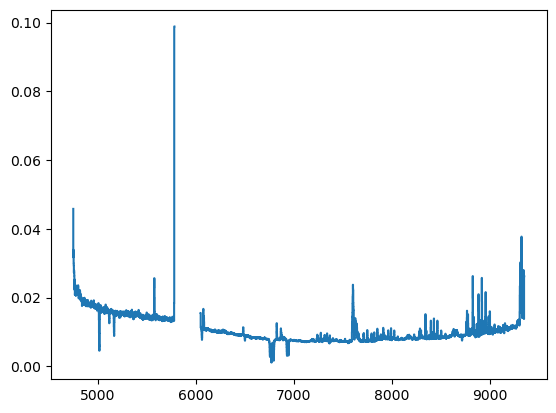

In [ ]:
plt.step(obs["wavelength"],obs["unc"]/obs["spectrum"])

In [7]:
obs = build_obs(**run_params)
model = build_model(**run_params)
sps = build_sps(**run_params)

print(model)
#print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
#print("Initial parameter dictionary:\n{}".format(model.params))
print(sps.ssp.libraries)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=8,maxi=11)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0. 0. 0. 0. 0.],scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3],df=[2. 2. 2. 2. 2. 2. 2.])
  sigma_smooth: <class 'prospect.models.priors.TopHat'>(mini=50,maxi=250)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.0316] 
  mass: [1000000.] <function logsfr_ratios_to_masses at 0x7f35b586fe20>
  sfh: [3] 
  imf_type: [0] 
  dust_type: [2] 
  agebins: [[ 0.          6.4772    ]
 [ 6.4772      7.        ]
 [ 7.          7.6132279 ]
 [ 7.6132279   8.2264558 ]
 [ 8.2264558   8.8396837 ]
 [ 8.8396837   9.45291159]
 [ 9.45291159 10.06613949]
 [10.06613949 10.13672057]] 
  lumdist: [143.36818743] 
  add_neb_emission: 

In [9]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 6

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/prospect/models/priors.py:125: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optmization in 183.13873839378357s


{'optimization': ([     message: `xtol` termination condition is satisfied.
        success: True
         status: 3
            fun: [ 9.871e+00  1.298e+01 ...  5.230e+00  1.053e+00]
              x: [-7.014e-01  9.949e-01  1.007e+01 -3.995e+00  8.364e+00
                  -8.091e+00  2.359e+00  4.035e-01  9.723e-01 -8.294e+00
                   3.000e+02]
           cost: 162928.0299689703
            jac: [[ 1.274e+01  1.431e+01 ... -6.741e-03 -2.752e+20]
                  [ 1.970e+01  2.217e+01 ... -1.042e-02 -2.752e+20]
                  ...
                  [ 6.005e+01  3.586e+01 ... -2.407e-02 -2.752e+20]
                  [ 3.309e+01  1.976e+01 ... -1.392e-02 -2.752e+20]]
           grad: [-2.110e+05 -5.010e+04  6.105e+05 -4.547e-03 -1.688e+02
                  -1.688e+02 -1.769e+02 -1.768e+02 -1.766e+02 -1.766e+02
                  -1.043e+24]
     optimality: 1.0430749833205607e+24
    active_mask: [0 0 0 0 0 0 0 0 0 0 0]
           nfev: 228
           njev: None,
        m

In [11]:
import pandas as pd
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
theta_best = results[ind_best].x.copy()
best_fit=pd.DataFrame({"value":theta_best},index=model.free_params)

print(best_fit)


# generate model
prediction = model.predict(theta_best, obs=obs, sps=sps)
#prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

plt.figure(figsize=(16,8))

# plot Data, best fit model, and old models
#plt.loglog(wspec, initial_spec, label='Old model spectrum',
#       lw=0.7, color='gray', alpha=0.5)
wspec=obs['wavelength']
plt.step(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)

plt.errorbar(wspec[obs['mask']]/(1+z), obs['spectrum'][obs['mask']], yerr=obs['unc'][obs['mask']], 
         label='Observed spectrum',
          markersize=10, alpha=0.8, ls='',
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot filter transmission curves
'''
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
'''
# Prettify
xmin=np.min(wspec)
xmax=np.max(wspec)
ymin=np.min(pspec)
ymax=np.max(pspec)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
#plt.xlim([7000, 9000])
plt.ylim([ymin, ymax])
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

ValueError: Length of values (11) does not match length of index (5)

In [284]:
np.min(wspec)

4749.595214843749

In [ ]:
from prospect.plotting import sfh
import pandas as pd
#times=np.logspace(-1,1.1336,100)
times=np.linspace(0.0,13.6,500)
'''
sfr=sfh.parametric_sfr(times=times,mass=best_fit.loc["mass"].value\
                       ,dust2=best_fit.loc["dust2"],tage=13.6\
                       ,tau=best_fit.loc["tau"],fburst=best_fit.loc["fburst"]\
                      ,fage_burst=best_fit.loc["fage_burst"])
'''

plt.yscale("log")
plt.xscale("log")
plt.plot(times,sfr)

In [259]:
smass=np.trapz(sfr,x=times*1e9)

In [260]:
print("%e"%smass)

9.460703e+08


## Let's try EMCEE which may be faster than dynesty

In [264]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [265]:
import mpi4py
from mpi4py import MPI
from schwimmbad import MPIPool
from functools import partial

lnprobfn_fixed = partial(lnprobfn, sps=sps)
mpi4py.rc.threads = False
mpi4py.rc.recv_mprobe = False

comm = MPI.COMM_WORLD
size = comm.Get_size()

withmpi = comm.Get_size() > 1

with MPIPool() as pool:
# The subprocesses will run up to this point in the code
    if not pool.is_master():
        pool.wait()
        sys.exit(0)
    nprocs = pool.size
    output = fit_model(obs, model, sps, noise, pool=pool, queue_size=nprocs, lnprobfn=lnprobfn_fixed, **run_params)


ValueError: Tried to create an MPI pool, but there was only one MPI process available. Need at least two.

In [262]:

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=128


/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/prospect/models/priors.py:125: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


There was an error during the likelihood call at parameters [1.22336339e+09 5.70323645e-01 8.41584420e+01 1.82303202e-01
 9.54484602e-01 5.00250936e+01]
emcee: Exception while calling your likelihood function:
  params: [1.22336339e+09 5.70323645e-01 8.41584420e+01 1.82303202e-01
 9.54484602e-01 5.00250936e+01]
  args: []
  kwargs: {'obs': {'filters': [<class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitzer_irac_ch2), <class 'sedpy.observate.Filter'>(spitzer_irac_ch3), <class 'sedpy.observate.Filter'>(spitzer_irac_ch4)], 'maggies': None, 'maggies_unc': None, 'phot_mask': None, 'phot_wave': None, 'wavelength': array([4749.59521484, 4750.84521484, 4752.09521484, ..., 9348.34521484,
       9349.59521484, 9350.84521484]), 'spectrum': array([3.09638366e-08, 2.89445357e-08, 2.48528321e-08, ...,
       1.01515269e-07, 9.68460459e-08, 0.00000000e+00]), 'unc': array([1.41806191e-09, 9.18337291e-10, 8.42856204e-10, ...,
       1.40039249e-09, 2.54063875e-09, 

Traceback (most recent call last):
  File "/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/prospect/fitting/fitting.py", line 114, in lnprobfn
    spec, phot, x = model.predict(theta, obs, sps=sps, sigma_spec=sigma_spec)
  File "/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/prospect/models/sedmodel.py", line 101, in predict
    self._wave, self._spec, self._mfrac = sps.get_galaxy_spectrum(**self.params)
  File "/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/prospect/sources/galaxy_basis.py", line 109, in get_galaxy_spectrum
    wave, spec = self.ssp.get_spectrum(tage=self.ssp.params['tage'],
  File "/disk/bifrost/yuanze/anaconda3/envs/prospect/lib/python3.10/site-packages/fsps/fsps.py", line 609, in get_spectrum
    self._compute_csp()
 

KeyboardInterrupt: 

In [140]:
from prospect.plotting import figuremaker, utils as putils
import prospect.io.read_results as reader
import importlib
importlib.reload(figuremaker)
def load_source_from_file(file_path):
    with open(file_path, 'r') as file:
        source_code = file.read()
    return source_code

results_type = "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("test_all_line_{}_mcmc.h5".format(results_type), dangerous=False)
result['run_params']["param_file"]=multiAGNpath+"/fitting/my_module_all_line.py"
result["paramfile_text"]=load_source_from_file(result['run_params']["param_file"])

fm= figuremaker.FigureMaker()


In [147]:
#theta_labels=result["theta_labels"]
fm.result=result
fm.model = reader.get_model(fm.result)
fm.sps = None
fm.obs = obs
fm.chain = figuremaker.chain_to_struct(fm.result["chain"], fm.model)
fm.weights = fm.result.get("weights", None)
fm.ind_best = np.argmax(fm.result["lnprobability"])
fm.parchain = fm.convert(fm.chain)
fm.make_seds()


building sps from paramfile


In [155]:
spec,phot,sed,cal=fm.draw_seds(100)

[ 4.42695884e+09  1.33962221e-01  1.93130867e+00  3.83458047e+00
  8.61003040e+01 -2.92189885e+00]


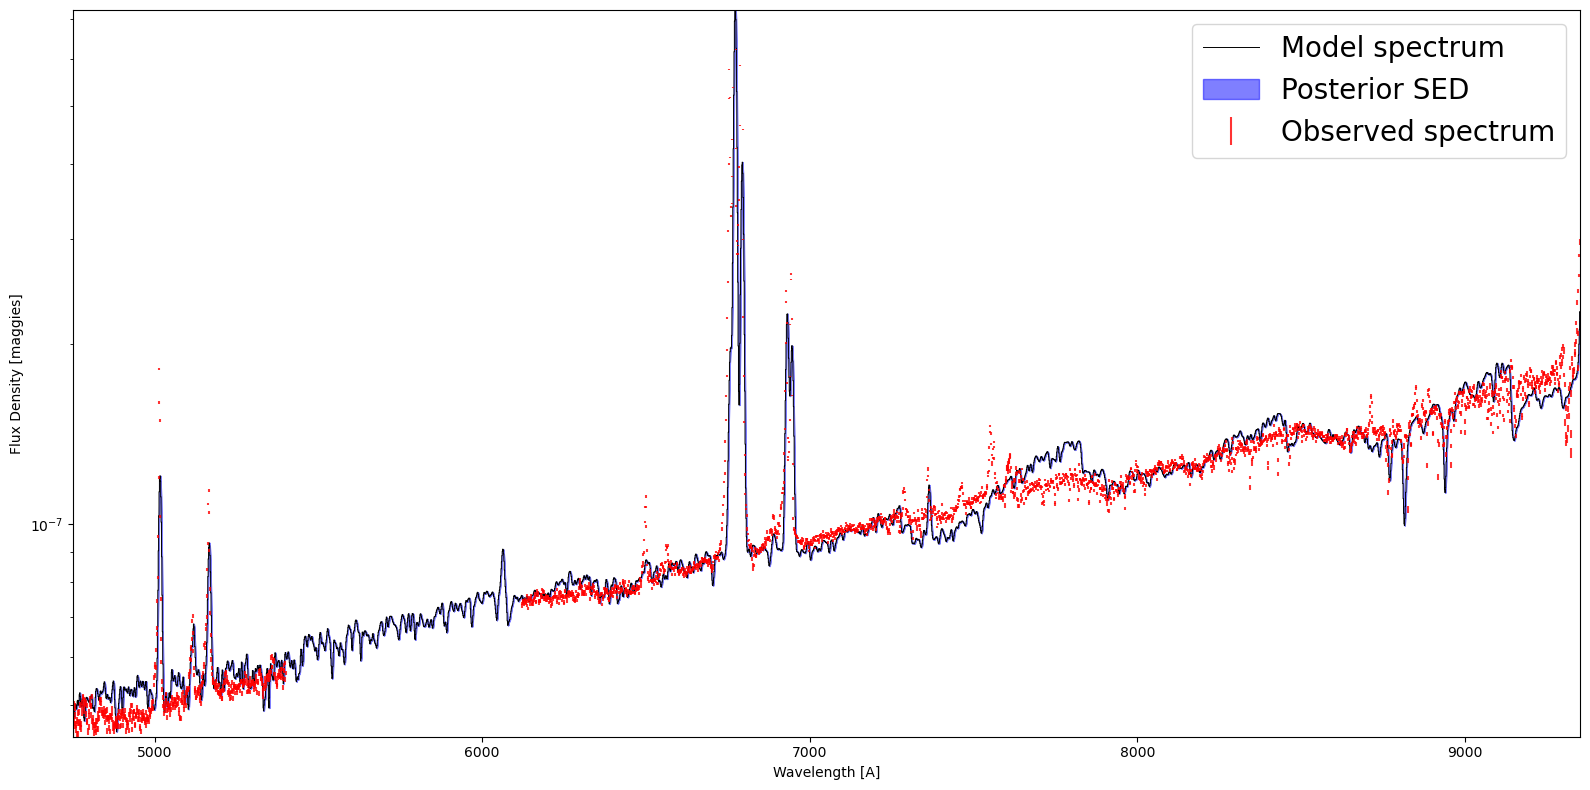

In [163]:

theta_best=np.mean(result["chain"],axis=0)
print(theta_best)

# generate model
prediction = fm.model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

median = np.percentile(sed, 50, axis=0)
lower_cred = np.percentile(sed, 16, axis=0)
upper_cred = np.percentile(sed, 84, axis=0)

plt.figure(figsize=(16,8))

# plot Data, best fit model, and old models
#plt.loglog(wspec, initial_spec, label='Old model spectrum',
#       lw=0.7, color='gray', alpha=0.5)
wspec=obs['wavelength']
plt.step(wspec, median, label='Model spectrum', 
       lw=0.7, color='k', alpha=1)

plt.errorbar(wspec[obs['mask']], obs['spectrum'][obs['mask']], yerr=obs['unc'][obs['mask']], 
         label='Observed spectrum',
          markersize=10, alpha=0.8, ls='',
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
ax=plt.gca()


plt.fill_between(wspec, lower_cred, upper_cred, color='blue', alpha=0.5, label='Posterior SED')


#for isamp in range(spec.shape[0]):
#    plt.step(wspec, sed[isamp],
 #      lw=0.7, color='slateblue', alpha=0.1)
# plot filter transmission curves
'''
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
'''
# Prettify
xmin=np.min(wspec)
xmax=np.max(wspec)
ymin=np.min(pspec)
ymax=np.max(pspec)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
#plt.xlim([7000, 9000])
plt.ylim([ymin, ymax])
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [149]:
from prospect.plotting import sfh
times=np.linspace(0.0,13.6,100)
sfr=sfh.parametric_sfr(times=times,tage=theta_best[2],tau=theta_best[3],mass=theta_best[0],dust2=theta_best[1])
plt.plot(times,sfr)

(10, 3682)

In [49]:
print(result.keys())
result[""]

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


array([-2.89802211e+10, -9.39885674e+09, -8.60716169e+09, ...,
       -2.63868885e+06, -2.63868885e+06, -2.63868885e+06])

In [61]:
multiAGNpath

'/disk/bifrost/yuanze/multiAGN'

In [83]:
import prospect.io as pio

In [100]:
param_file = (result['run_params'].get('param_file', ''),
                  result.get("paramfile_text", ''))
path, filename = os.path.split(param_file[0])
modname = filename.replace('.py', '')
#user_module = import_module_from_string(param_file[1], modname)
user_module=pio.import_module_from_string(param_file[0],modname)

AttributeError: module 'prospect.io' has no attribute 'import_module_from_string'

In [90]:
def load_source_from_file(file_path):
    with open(file_path, 'r') as file:
        source_code = file.read()
    return source_code